In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from skimage.draw import circle_perimeter_aa
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/u/v/a/vaishnavi_b/Desktop/Circle-Detection-ML-Challenge-/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
import utils
from torch.utils.data import DataLoader, TensorDataset
from timeit import default_timer as timer
from model import CNNModel
from train import test_step, train_step
from utils import calculate_accuracy, print_train_time

In [10]:
import os
import pickle
def generate_data(noise_level=0.5, img_size=100, num_samples=1000):
    # Define the file path based on the configurations
    file_path = f'data/noise_{noise_level}_size_{img_size}_samples_{num_samples}.pkl'

    # Adjust the file path to the desired location outside the "src" folder
    file_path = os.path.join(os.pardir, file_path)

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    print(file_path)

    if os.path.exists(file_path):
        # If the pickle file exists, load the data
        with open(file_path, 'rb') as file:
            dataset = pickle.load(file)
        print(f'Data loaded from {file_path}')
    else:
        # If the pickle file does not exist, generate the data and save it
        min_radius = img_size // 10
        max_radius = img_size // 2

        data_generator = generate_examples(noise_level=noise_level, img_size=img_size, min_radius=min_radius, max_radius=max_radius)

        # Generate and save the data
        dataset = [next(data_generator) for _ in range(num_samples)]

        # Save the dataset using pickle
        with open(file_path, 'wb') as file:
            pickle.dump(dataset, file)
        print(f'Data saved to {file_path}')

    return dataset

In [11]:
# from prepare_data import generate_data, get_train_test_data


data = generate_data(noise_level=0.1, img_size=100, num_samples=30000)

../data/noise_0.1_size_100_samples_30000.pkl


ModuleNotFoundError: No module named 'src'

In [5]:
train_loader, test_loader = get_train_test_data(noise_level=0.1, img_size=100, num_samples=30000)

../data/noise_0.1_size_100_samples_30000.pkl


ModuleNotFoundError: No module named 'src'

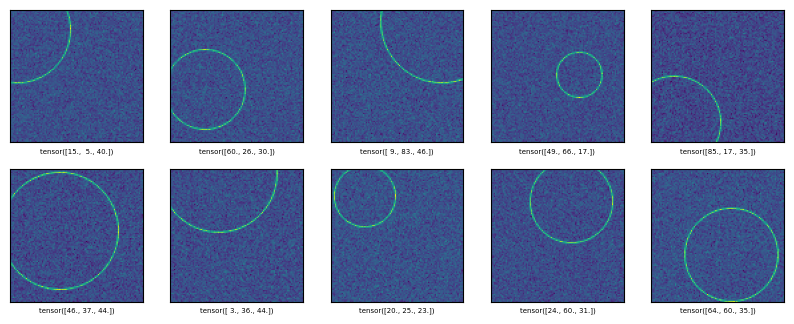

In [5]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    train_features_batch, train_labels_batch = next(iter(train_loader))
    plt.imshow(train_features_batch[i].squeeze())
    plt.xlabel(train_labels_batch[i], fontsize = 5)

In [6]:
from torch import nn
class m0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [7]:
import torch.nn.functional as F
from torch import nn


class m1(nn.Module):
    def __init__(self, input_shape=1, hidden_units=64, output_shape=3, img_size=100):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1), # [1, 64]
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1), #[64, 128]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, padding=1, stride=1),#[128, 256]
            nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),#[256, 256]
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out_layer = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=hidden_units*4*25*25, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # # print(x.shape)
        x = self.conv_block2(x)
        # # print(x.shape)
        x = self.out_layer(x)
        # print(x.shape)
        return x

In [8]:

# cuda.empty_cache()


model = m1().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.0001)

In [9]:


torch.manual_seed(42)
start_time= timer()
print("Hi")
epochs = 2
train_losses = []
test_losses = []
test_accs = []
epochs_ = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_loss, train_acc = train_step(model = model,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    test_loss, test_acc = test_step(model = model,
               data_loader=test_loader,
               loss_fn=loss_fn,
               calculate_accuracy=calculate_accuracy,
               device=device
               )

    epochs_.append(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc)





    # Calculate training time
    end_time = timer()
    total_train_time_model = print_train_time(start=start_time,
                                                end=end_time,
                                                device=str(next(model.parameters()).device))

Hi


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0
--------
cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacty of 44.40 GiB of which 125.31 MiB is free. Process 1304403 has 14.01 GiB memory in use. Process 3490174 has 14.09 GiB memory in use. Process 3687544 has 14.03 GiB memory in use. Including non-PyTorch memory, this process has 1.97 GiB memory in use. Of the allocated memory 489.98 MiB is allocated by PyTorch, and 126.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
nvcc --version

NameError: name 'nvcc' is not defined